In [9]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [10]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values
X = ((X / 255.) - .5) * 2

In [11]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=123, stratify=y_temp)

In [12]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        # First hidden layer
        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)

        # Second hidden layer
        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)

        # Output layer
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # First hidden layer
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Second hidden layer
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):
        # One-hot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        #########################
        ### Output layer weights
        #########################

        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)  # sigmoid derivative
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        d_z_out__dw_out = a_h2
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        #################################
        ### Second hidden layer weights
        #################################

        d_z_out__a_h2 = self.weight_out
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2)
        delta_h2 = d_loss__a_h2 * d_a_h2__d_z_h2

        d_z_h2__d_w_h2 = a_h1
        d_loss__d_w_h2 = np.dot(delta_h2.T, d_z_h2__d_w_h2)
        d_loss__d_b_h2 = np.sum(delta_h2, axis=0)

        #################################
        ### First hidden layer weights
        #################################

        d_z_h2__a_h1 = self.weight_h2
        d_loss__a_h1 = np.dot(delta_h2, d_z_h2__a_h1)
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1)
        delta_h1 = d_loss__a_h1 * d_a_h1__d_z_h1

        d_z_h1__d_w_h1 = x
        d_loss__d_w_h1 = np.dot(delta_h1.T, d_z_h1__d_w_h1)
        d_loss__d_b_h1 = np.sum(delta_h1, axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h1, d_loss__d_b_h1)




In [13]:
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                              + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]

In [17]:
def compute_mse_acc_auc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    all_targets = []
    all_probas = []
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):
        _, _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

        all_targets.append(onehot_targets)
        all_probas.append(probas)

    # Concatenate all minibatch results
    all_targets = np.vstack(all_targets)
    all_probas = np.vstack(all_probas)

    # Compute macro AUC
    macro_auc = 0
    for i in range(num_labels):
        macro_auc += roc_auc_score(all_targets[:, i], all_probas[:, i])
    macro_auc /= num_labels

    mse = mse / (i + 1)
    acc = correct_pred / num_examples
    return mse, acc, macro_auc

In [18]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, minibatch_size=100, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_auc = []
    epoch_valid_auc = []

    for e in range(num_epochs):

        # Iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            (d_loss__dw_out, d_loss__db_out,
             d_loss__d_w_h2, d_loss__d_b_h2,
             d_loss__d_w_h1, d_loss__d_b_h1) = model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_out -= learning_rate * d_loss__dw_out
            model.bias_out -= learning_rate * d_loss__db_out
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1

        train_mse, train_acc, train_auc = compute_mse_acc_auc(model, X_train, y_train)
        valid_mse, valid_acc, valid_auc = compute_mse_acc_auc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_train_auc.append(train_auc)
        epoch_valid_auc.append(valid_auc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e + 1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.6f} '
              f'| Train Acc: {train_acc:.6f}% '
              f'| Valid Acc: {valid_acc:.6f}%'
              f'| Train Auc: {train_auc:.6f}'
              f'| Valid Auc: {valid_auc:.6f}')

    return epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc

In [19]:
num_epochs = 50
minibatch_size = 100
learning_rate = 0.1

model = NeuralNetMLP(num_features=28 * 28,
                     num_hidden1=50,
                     num_hidden2=50,
                     num_classes=10)

epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc = train(model, X_train, y_train, X_valid,
                                                                                       y_valid,
                                                                                       minibatch_size=minibatch_size,
                                                                                       num_epochs=num_epochs,
                                                                                       learning_rate=learning_rate)

Epoch: 001/050 | Train MSE: 3.501899 | Train Acc: 15.645408% | Valid Acc: 15.673469%| Train Auc: 0.759142| Valid Auc: 0.760376
Epoch: 002/050 | Train MSE: 3.457234 | Train Acc: 27.604592% | Valid Acc: 27.877551%| Train Auc: 0.858279| Valid Auc: 0.860366
Epoch: 003/050 | Train MSE: 3.313467 | Train Acc: 28.806122% | Valid Acc: 28.755102%| Train Auc: 0.885285| Valid Auc: 0.887428
Epoch: 004/050 | Train MSE: 2.933904 | Train Acc: 40.308673% | Valid Acc: 40.204082%| Train Auc: 0.890270| Valid Auc: 0.892387
Epoch: 005/050 | Train MSE: 2.548985 | Train Acc: 55.561224% | Valid Acc: 55.714286%| Train Auc: 0.911840| Valid Auc: 0.914249
Epoch: 006/050 | Train MSE: 2.128958 | Train Acc: 67.709184% | Valid Acc: 68.153061%| Train Auc: 0.931970| Valid Auc: 0.933593
Epoch: 007/050 | Train MSE: 1.789704 | Train Acc: 74.076531% | Valid Acc: 74.214286%| Train Auc: 0.944392| Valid Auc: 0.945682
Epoch: 008/050 | Train MSE: 1.528018 | Train Acc: 80.744898% | Valid Acc: 81.438776%| Train Auc: 0.956998| Vali

## Evaluating the neural network performance

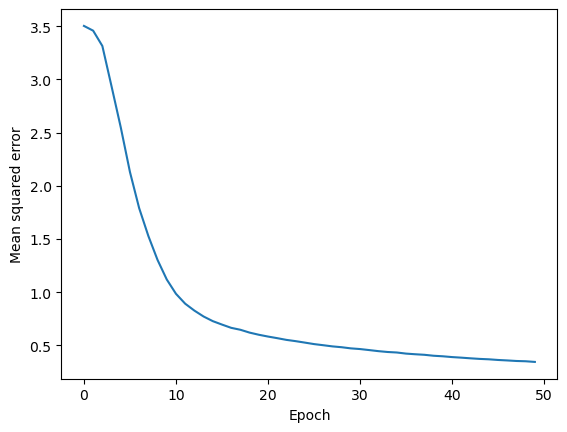

In [20]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

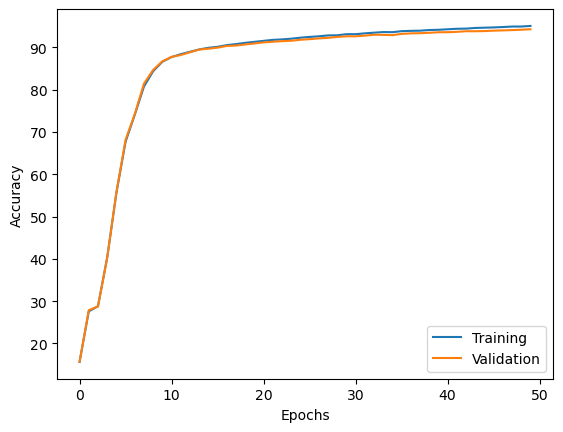

In [21]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

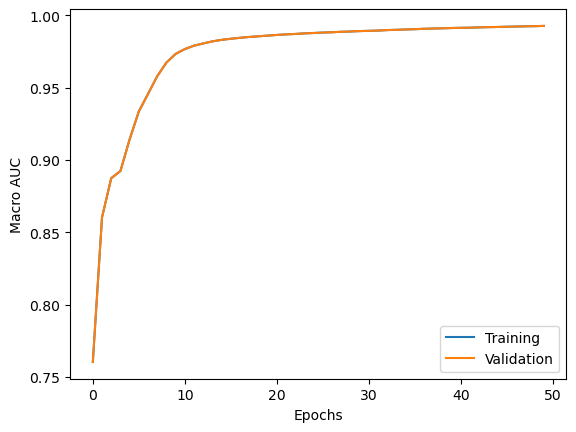

In [22]:
plt.plot(range(len(epoch_train_auc)), epoch_valid_auc,
         label='Training')
plt.plot(range(len(epoch_valid_auc)), epoch_valid_auc,
         label='Validation')
plt.ylabel('Macro AUC')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [24]:
test_mse, test_acc, test_auc = compute_mse_acc_auc(model, X_test, y_test)
print(f'Test MSE: {test_mse:.6f}')
print(f'Test accuracy: {test_acc * 100:.6f}%')
print(f'Test auc: {test_auc:.6f}%')

Test MSE: 0.209690
Test accuracy: 94.076190%
Test auc: 0.992058%
